<hr style="height: 4px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='#38610B'>Projet VII - Prédictions de Revenus</font>


#### Mission 3 - Etude Mobilité intergénérationnelle du revenu 
    - Etudes Coefficients Elasticité
<u>Les données sont issues de</u> :
- Openclassrooms (<a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/projet_7.zip">Coefficients d'elasticité</a>)  
- Banque Mondiale - World Bank Open Data (<a href="http://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim">Coefficients d'elasticité</a>)  

<u>DataFrames pandas utilisés et critères de téléchargement</u> :  

* <font color='#013ADF'>DataFrame <strong>pj7</strong></font> : Fichier enrichi, nettoyé avec datas de wid, gini , pop  & gdim
 Dataframe issu de l'etude précédente.

  
**<font color='#38610B'>- Date : 5 Aout 2019</font>**  
Auteur : Frédéric Boissy
<hr style="height: 4px; color: #839D2D; width: 100%; ">


#### Initialisation (Libraries - Functions - etc...)

In [1]:
import time   # Librairie temps pour calculs durée par exemple
trt_start_time = time.time()

# -*- coding: utf8 -*-
from init_libraries import *
# /////  Pour executer des requetes SQL de verification sur des DF  /////
from pandasql            import sqldf
execsql = lambda q: sqldf(q, globals())   

# Limiter le nombre de lignes d'affichage des Dataframes
pd.options.display.max_rows=30

#### DEBUGGER python
Ajout de ligne BKP avec commande breakpoint() à l'endroit désiré.  
* Actions autorisées : c/n/s/q
    * c - continue execution
    * n - step to the next line within the same function
    * s - step to the next line in this function or a called function
    * q - quit the debugger/execution


In [2]:
import pdb
# breakpoint()

In [3]:
# CREATION FONCTION FILTRE sur les dataframes avec Multi-Index

def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]
pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by

# exemple utilisation
# wid500.filter_by({'country_code' : ['ALB', 'ARG', 'ARM'], 'c_i_child' : [1, 2]})

<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Data "pj7" enrichi de l'etude précédente</font>   
- <b>Fusion de wid, pop , gini & gdim</b>

In [4]:
pj7 = pd.read_csv("OUTFILES/pj7_m3.csv")
print("Dimension Tableau : ", pj7.shape, "  ///  Nombre de Pays :", pj7.shape[0]/100, "  ///")
pj7.sort_values(['country_code', 'c_i_child'], ascending=True, inplace=True)
pj7.head()

Dimension Tableau :  (11200, 6)   ///  Nombre de Pays : 112.0   ///


,country_code,c_i_child,pj,income,gini,gdpppp
0,ALB,1,0.816,728.898,30.300,"7,297.000"
1,ALB,2,0.816,916.662,30.300,"7,297.000"
2,ALB,3,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,4,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,5,0.816,"1,132.700",30.300,"7,297.000"


In [5]:
# RAPPEL DE NOTRE SELECTION DE PAYS PRECEDENTE
lib_pays = ["Iceland", "France", "Slovenia", "Argentina", "Honduras", "Indonesia"]
cod_pays = ["ISL", "FRA", "SVN", "ARG", "HND", "IDN"]
col_pays = ["#8000FF", "#0040FF", "#DF7401", "#81DAF5", "green", "red"]

<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M3 - Détertmination Coefficients d'élasticité</u></font>


<img src="DATA/images/Recap_M3.png" width="500" align="left">

- Detail "counter" module Collections (<a href="http://www.python-simple.com/python-modules-structures-donnees/collections.php">from collections import Counter</a>)  



In [6]:
from collections import Counter

<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.1 Générations d'un grand nombre (n) de Réalisations de la : </font> Variable $ln(Y_{(parent})$

... que nous appellerons <font color="darkblue"><b>$ln(Y_{(parent})$ </b></font> selon une loi normale.   
Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final.  
Dans notre exemple, prenons :
- $\mu$ = 4 (moyenne). Un revenu moyen de 15'000 donne un log(15000) ~= 4.17
- $\sigma$ = 1  (ecart-type, choisi arbitrairement)


<u>Prérequis</u> :  $(n)$ doit être > 1000 x le Nbre_quantiles  

In [7]:
pd.options.display.max_rows=10
# Génération des revenus des parents (exprimés en logs) selon une loi normale.
# un revenu de 15'000 donne un log(15000) ~= 4  ... prenons un ecart-type de 1.5

nb_quantiles = 100                 # nombre de quantiles (nombre de classes de revenu)
nb_real      = 1000*nb_quantiles   # taille de l'échantillon
idx = [i+1 for i in np.arange(0, nb_real)]

ln_y_parent = st.norm(4,1).rvs(size=nb_real)
df31 = pd.DataFrame({'ln_Y_parent': ln_y_parent}, index = idx)
df31.tail()

,ln_Y_parent
99996,3.489
99997,4.145
99998,3.630
99999,4.128
100000,3.912


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.2 Générations n Réalisations du Terme d'erreurs</font> 

Généré selon une loi normale de moyenne ($\mu$ = 0)et d'écart-type ($\sigma$ = 1).  
#### Rappel de la formule proposée pour notre étude

<img src="DATA/images/formule1_m3.png" width="300" align="left">
<br><br>

Ici, <font color="darkred" size=4>$ε$</font> = Terme d'erreur du resultat  


In [8]:
epsilon = st.norm(0,1).rvs(size=nb_real)
df32 = pd.DataFrame({'ln_Y_parent': ln_y_parent, 'Terme_Erreur': epsilon}, index = idx)
df32.tail()

,ln_Y_parent,Terme_Erreur
99996,3.489,0.865
99997,4.145,2.092
99998,3.630,-0.817
99999,4.128,2.664
100000,3.912,-1.055


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.3 Calcul de la : </font> Variable $Y_{(child)}$
#### Fonction : <i><font color="darkblue">generate_incomes (n, pj)</font></i>
Renvoie les Variables <b><font color="darkblue">$Y_{(child)}$ et $Y_{(parent)}$ </font></b>  
D'après la Formule :  
    
<img src="DATA/images/formule1_m3.png" width="300" align="left">
<br>
<br>  

- $n$ = est le nombre d'éléments dans l'array  
- $pj$ = est le coefficient d'àlasticité (mobilité intergénérationnelle des revenus dans un pays)


$\alpha$ étant sans incidence, on ne l'utilise pas.
Dans notre exemple, prenons un coefficient d'élasticité :
- $\rho_{j}$ = 0.9 



<u>Prérequis</u> :  $(n)$ doit être > 1000 x le Nbre_quantiles  

In [9]:
pj = 0.9   # coefficient d'élasticité du pays j

# Creation d'une fonction qui retourne, les revenus enfants, parents et le taux d'erreur
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

xvar = y_child, y_parent = generate_incomes(nb_real, pj)
idx = [i+1 for i in np.arange(0,len(y_child))]
df33 = pd.DataFrame({'Y_child': y_child, 'Y_parent': y_parent}, index = idx)
df33.tail()

,Y_child,Y_parent
99996,0.766,1.153
99997,3.888,2.338
99998,1.204,0.251
99999,3.188,2.025
100000,22.466,3.762


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.4 Détermination des Classes de revenus : </font> Variables  $c_{(i,child)}$ et $c_{(i,parent)}$

Respectivement à partir de revenus $Y_{(child)}$ et de $Y_{(parent)}$

#### Fonction : <i><font color="darkblue">quantiles (l, nb_quantiles)</font></i>
Détermine la classe d'un individu.  
Crée un array composé de l'élément auxquel est associé un chiffre compris entre 1 et le nb_quantiles

#### Fonction : <i><font color="darkblue">compute_quantiles (y_child, y_parent, nb_quantiles)</font></i>
Cette fonction détermine les classes <b><font size=4 color="darkblue">$c_{(i,child)}$  $c_{(i,parent)}$ </font></b>  
Elle renvoie un dataframe contenant les quantiles associés aux variables y_child et y_parent

In [10]:
# Creation d'une fonction qui détermine la classe d'un individu ...
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

# Creation d'une fonction qui retourne un dataframe avec les individus et leurs classe
def compute_quantiles(y_child, y_parent, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parent = pd.Series(y_parent)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parent, nb_quantiles)
    sample = pd.concat([y_child, y_parent, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parent", "c_i_child","c_i_parent"]
    return sample

df34 = compute_quantiles(y_child, y_parent, nb_quantiles)
df34

,y_child,y_parent,c_i_child,c_i_parent
0,2.913,6.750,79,98
1,0.050,0.296,2,12
2,0.913,0.591,48,30
3,3.992,2.608,85,84
4,2.267,0.585,73,30
...,...,...,...,...
99995,0.766,1.153,43,56
99996,3.888,2.338,85,81
99997,1.204,0.251,56,9
99998,3.188,2.025,81,76


In [11]:
reqsql = '''
Select * from df34
where  (c_i_child < c_i_parent) and (y_child > y_parent)
'''
dfsql=execsql(reqsql)
dfsql

,y_child,y_parent,c_i_child,c_i_parent
0,2.543,2.256,76,80
1,5.728,4.695,91,94
2,2.945,2.524,79,83
3,3.254,3.223,81,88
4,3.260,3.260,81,89
...,...,...,...,...
4572,4.030,3.730,85,91
4573,10.066,6.534,96,97
4574,1.942,1.898,69,74
4575,3.735,3.360,84,89


Creation d'un dataframe contenant les proportions de couples classe_enfant/parent

In [12]:
df34.sort_values(['c_i_child', 'c_i_parent'], ascending=True, inplace=True)
df34prop = df34.groupby(["c_i_child","c_i_parent"]).apply(len) / df34.groupby(['c_i_child'])[["c_i_parent"]].apply(len)
df34prop = df34prop.reset_index()
df34prop.columns = ["c_i_child","c_i_parent","prop_couples"]
df34prop.head(5)

,c_i_child,c_i_parent,prop_couples
0,1,1,0.249
1,1,2,0.122
2,1,3,0.086
3,1,4,0.066
4,1,5,0.040


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.5 Estimation des Distribution conditionnelles des Classes </font> 

#### Fonction : <i><font color="darkblue">distribution (counts, nb_quantiles)</font></i>
Cette fonction détermine la propotion d'une classe.  
Elle n'est utilisée que dans la fonction suivante :
#### Fonction : <i><font color="darkblue">conditional_distributions (sample, nb_quantiles)</font></i>
Cette fonction détermine les distributions conditionnelles en proportion des couples <b><font size=4 color="darkblue">$c_{(i,child)}$ / $c_{(i,parent)}$ </font></b>  
Elle retourne une matrice (array) et un dataframe de ces valeurs

In [13]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat), pd.DataFrame(mat)

array35, df35 = conditional_distributions(df34, nb_quantiles)
df35

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.249,0.122,0.086,0.066,0.040,0.053,0.040,0.032,0.026,0.024,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.111,0.097,0.070,0.070,0.058,0.041,0.046,0.044,0.035,0.025,...,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000
2,0.078,0.071,0.064,0.060,0.053,0.044,0.043,0.033,0.029,0.043,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.075,0.064,0.060,0.056,0.041,0.049,0.035,0.042,0.037,0.027,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.041,0.068,0.051,0.039,0.051,0.035,0.036,0.039,0.032,0.027,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.026,0.038,0.031,0.036,0.039,0.035,0.035,0.059,0.054,0.057
96,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.025,0.039,0.035,0.037,0.033,0.055,0.040,0.048,0.074,0.069
97,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.026,0.037,0.034,0.036,0.043,0.049,0.062,0.063,0.070,0.095
98,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.033,0.036,0.031,0.051,0.052,0.053,0.063,0.071,0.084,0.130


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.6 Vérification des Fonctions & code avec Graphes </font> 

* Nombre de Classes (quantiles) du test = 10

* Coefficient d'élasticité testés :  $\rho_{j}$ = 0.1    ET   $\rho_{j}$ = 0.9 

#### Fonction : <i><font color="darkblue">plot_conditional_distributions (p, cd, nb_quantiles)</font></i>
Cette fonction qui permet de modéliser les distributions conditionnelles des couples <b><font size=4 color="darkblue">$c_{(i,child)}$ / $c_{(i,parent)}$ </font></b>  
Elle retourne un graphique

In [14]:
sns.set_style("ticks")
def plot_conditional_distributions(pays, p, cd, nb_quantiles):
    plt.figure(figsize=(10,6))
            
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title(pays + ' -- ' + r'$\rho_{j} = $' + str(p), size=15)
    plt.legend()
    plt.xlabel("Classe(quantile) parent", size=14)
    plt.ylabel("Probabilité Classe(quantile) enfant", size=14)
    txtfignam = "OUTFILES/M3-Dist_Cond_coeff_mob_inter_"+pays+".png"
    plt.savefig(txtfignam, dpi=100, bbox_inches='tight')
    plt.show()

Déterminons la liste des Pays et leur coefficient pj associé

In [15]:
loop = pj7.groupby(['country_code']).mean()['pj'].reset_index()
loop.head()

,country_code,pj
0,ALB,0.816
1,ARG,0.897
2,ARM,0.466
3,AUT,0.245
4,AZE,0.466


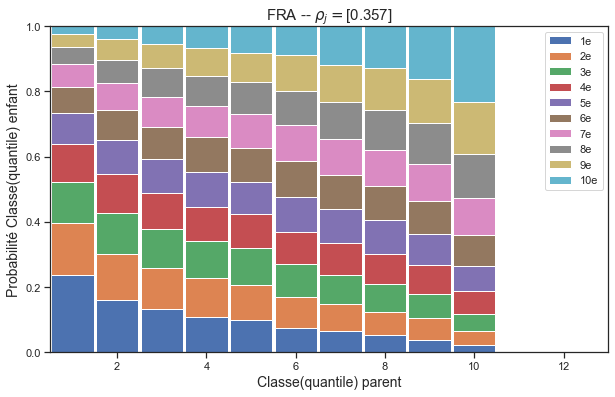

In [16]:
nb_quantiles = 10   # nombre de quantiles (nombre de classes de revenu)
pays='FRA'
pj = np.round(loop.loc[loop['country_code'] == pays]['pj'].values, 3)
y_child, y_parent = generate_incomes(nb_real, pj)
df36a = compute_quantiles(y_child, y_parent, nb_quantiles)
array36, df36 = conditional_distributions(df36a, nb_quantiles)
plot_conditional_distributions(pays, pj, array36, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10

Testons nos fonctions & code sur la liste des pays sélectionnées dans notre étude précédente

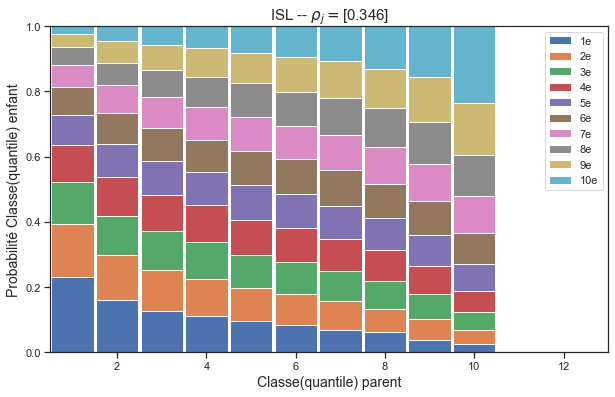

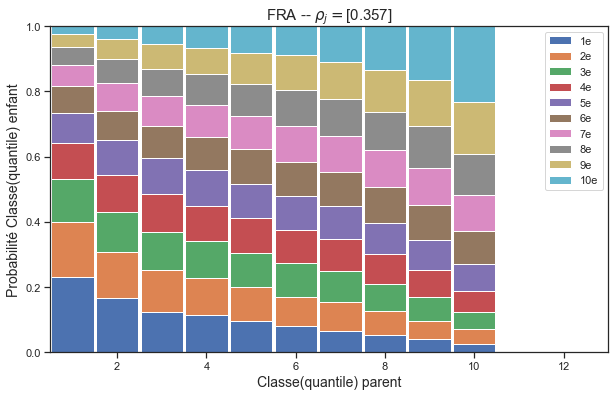

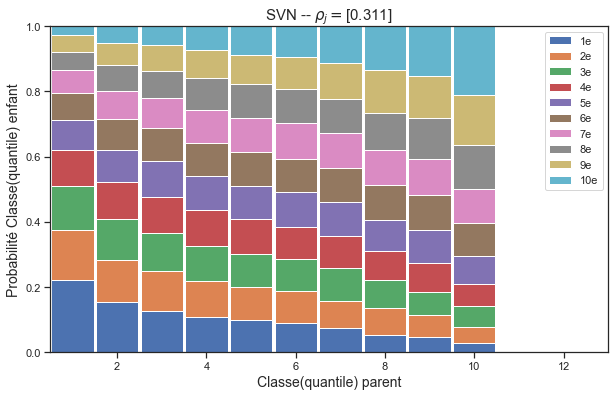

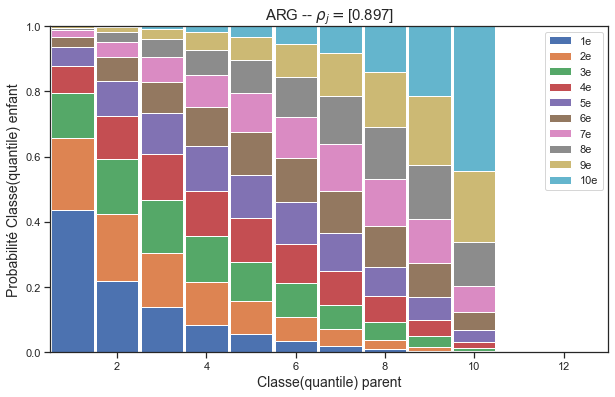

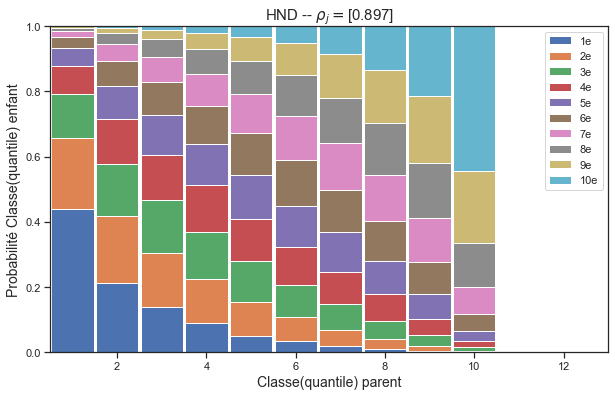

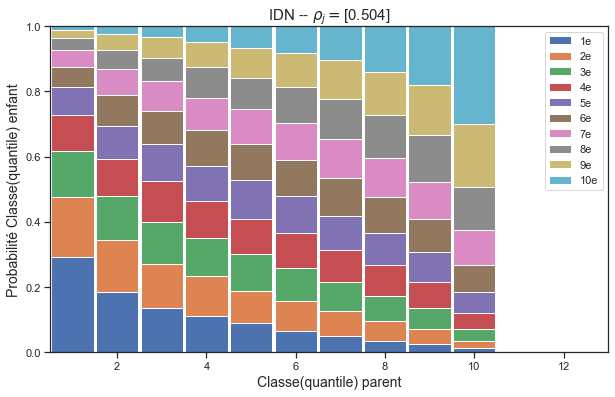

Durée du traitement : 5.79949 seconds


In [17]:
start_time = time.time()
nb_quantiles = 10   # nombre de quantiles (nombre de classes de revenu)
# /// -------------------------------------------------------------------------------------------------------///
for pays in cod_pays:
    pj = np.round(loop.loc[loop['country_code'] == pays]['pj'].values, 3)
    y_child, y_parent = generate_incomes(nb_real, pj)
    df36a = compute_quantiles(y_child, y_parent, nb_quantiles)
    array36, df36 = conditional_distributions(df36a, nb_quantiles)
    plot_conditional_distributions(pays, pj, array36, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
    
plt.close()
# /// -------------------------------------------------------------------------------------------------------///

duree = round(time.time() - start_time, 5)
print("Durée du traitement :", "%s seconds" % duree)

<hr style="height: 2px; background-color: #6D0101; width: 100%; ">

### <font color="#6D0101">3.7 Creation d'une fonction recap' de "Distribution Conditionnelle (proba)" :</font>  
<font color="darkblue" size=4><b>dist_cond</b> </font><font size=3><i>(n_size, n_quant, pj)</i></font>

Cette fonction regroupe (en interne) les fonctions suivantes  :  <b><font color="blue">generate_incomes / compute_quantiles</b>

* $n$ _ $quant$ et $n$ _ $size$ ne varient pas

<hr style="height: 2px; background-color: #6D0101; width: 100%; ">

##### <font color="#6D0101">Paramètres entrée :</font>
* n_size = taille de l'échantillon  
* n_quant = nombre de quantiles (classes)
* pj = coefficient d'élasticité (du pays)

##### <font color="darkgreen">Paramètres sortie :</font>
* dfcd = dataframe de la matrice de distribution des probabilités conditionnelle

In [18]:
def dist_cond(n_size, n_quant, pj):
    y_child, y_parent = generate_incomes(n_size, pj)
    sample = compute_quantiles(y_child, y_parent, n_quant)
    sample.sort_values(['c_i_child', 'c_i_parent'], ascending=True, inplace=True)
    return sample

In [19]:
pj      = 0.9
n_quant = 100               # nombre de quantiles (nombre de classes de revenu)
nb_real = 1000 * n_quant   # taille de l'échantillon

# Test Light
start_time = time.time()
df_test = dist_cond(nb_real, n_quant, pj)
duree = round(time.time() - start_time, 5)
print("Durée du traitement :", "%s seconds" % duree)    

df_test

Durée du traitement : 0.29225 seconds


,y_child,y_parent,c_i_child,c_i_parent
187,0.026,0.032,1,1
1495,0.033,0.089,1,1
1694,0.017,0.042,1,1
1820,0.014,0.041,1,1
2187,0.015,0.077,1,1
...,...,...,...,...
97968,24.357,21.153,100,100
98540,41.353,14.782,100,100
98845,30.467,16.411,100,100
99206,46.620,11.249,100,100


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.8 Préparation Jeu Essai WID x 500 </font>  

Pour chaque individu de la Wold Income Distribution, on crée 499 "clones".   
La taille du nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution.

In [20]:
wid500 = pj7.append([pj7]*499)
wid500.rename(columns={'IGEincome':'pj'}, inplace=True)
wid500 = wid500.astype({'country_code':'category', 'c_i_child':'int8'}) 
# wid500.set_index(['country_code', 'c_i_child'], inplace=True)
wid500.info()
wid500.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600000 entries, 0 to 11099
Data columns (total 6 columns):
country_code    category
c_i_child       int8
pj              float64
income          float64
gini            float64
gdpppp          float64
dtypes: category(1), float64(4), int8(1)
memory usage: 224.3 MB


,country_code,c_i_child,pj,income,gini,gdpppp
0,ALB,1,0.816,728.898,30.300,"7,297.000"
1,ALB,2,0.816,916.662,30.300,"7,297.000"
2,ALB,3,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,4,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,5,0.816,"1,132.700",30.300,"7,297.000"


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">3.9 Constitution des Classes : </font>  $c_{i,parent}$ selon les distributions conditionnelles calculées avant

Par exemple, si la probabilité $P(c_{i,parent}=8 | c_{i,child}=5, p_j=0.9) = 3$% (0.03),   
alors vous assignerez la classe $c_{i,parent}=8$ à 15 des 500 individus du pays ayant , car 500*0.03 = 15.

In [21]:
#  Réutilisons le pj du pays (calculé pour la question 6)
loop.head()

,country_code,pj
0,ALB,0.816
1,ARG,0.897
2,ARM,0.466
3,AUT,0.245
4,AZE,0.466


Creation des "n" lignes de classes parents en fonction du %age sur 500lignes

In [22]:
n_quant = 100               # nombre de quantiles (nombre de classes de revenu)
n_size  = 500 * n_quant    # taille de l'échantillon  (500 individus de 100 quantiles chacun)

start_time = time.time()
# /// -------------------------------------------------------------------------------------------------------///

df_class = pd.DataFrame()
for i in range(len(loop)):
    
    cc = loop.loc[i]['country_code']
    pj = loop.loc[i]['pj']
    cq = dist_cond(n_size, n_quant, pj)
    cq['country_code'] = cc
    df_class = df_class.append(cq, ignore_index = True)

# /// -------------------------------------------------------------------------------------------------------///
duree = round(time.time() - start_time, 5)
print("Durée du traitement :", "%s seconds" % duree)

Durée du traitement : 20.58499 seconds


In [23]:
df_class = df_class.astype({'country_code':'category', 'c_i_child':'int8', 'c_i_parent':'int8'}) 
df_class.info()
df_class.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600000 entries, 0 to 5599999
Data columns (total 5 columns):
y_child         float64
y_parent        float64
c_i_child       int8
c_i_parent      int8
country_code    category
dtypes: category(1), float64(2), int8(2)
memory usage: 101.5 MB


,y_child,y_parent,c_i_child,c_i_parent,country_code
0,0.028,0.082,1,1,ALB
1,0.048,0.068,1,1,ALB
2,0.049,0.080,1,1,ALB
3,0.033,0.060,1,1,ALB
4,0.045,0.046,1,1,ALB


### Fusion de WID500 et des classes

In [24]:
wid500.sort_values(['country_code', 'c_i_child'], ascending=True, inplace=True)
wid500.head()

,country_code,c_i_child,pj,income,gini,gdpppp
0,ALB,1,0.816,728.898,30.300,"7,297.000"
0,ALB,1,0.816,728.898,30.300,"7,297.000"
0,ALB,1,0.816,728.898,30.300,"7,297.000"
0,ALB,1,0.816,728.898,30.300,"7,297.000"
0,ALB,1,0.816,728.898,30.300,"7,297.000"


In [25]:
df_class = df_class[['country_code', 'c_i_child', 'c_i_parent']]
df_class.sort_values(['country_code', 'c_i_child'], ascending=True, inplace=True)
df_class.head()

,country_code,c_i_child,c_i_parent
0,ALB,1,1
1,ALB,1,1
2,ALB,1,1
3,ALB,1,1
4,ALB,1,1


Je rajoute la colonne "Classe_Parent" au Dataframe initial

In [26]:
wid500['c_i_parent'] = df_class['c_i_parent']

In [27]:
wid500

,country_code,c_i_child,pj,income,gini,gdpppp,c_i_parent
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
...,...,...,...,...,...,...,...
11099,ZAF,100,0.677,"82,408.550",63.733,"9,602.000",16
11099,ZAF,100,0.677,"82,408.550",63.733,"9,602.000",16
11099,ZAF,100,0.677,"82,408.550",63.733,"9,602.000",16
11099,ZAF,100,0.677,"82,408.550",63.733,"9,602.000",16


<hr style="height: 3px; color: #839D2D; width: 100%; ">

###  <font color='#61210B'><u>Export des Dataframes</u></font> :
#### Dans fichiers csv - Pour Régression Logistique

In [28]:
start_time = time.time()
wid500.to_csv('OUTFILES/wid500.zip', sep=',', encoding='utf-8', index=False, compression='zip')
# wid500.to_csv('OUTFILES/wid500.csv', sep=',', encoding='utf-8', index=False)
duree = round(time.time() - start_time, 5)
print("Durée de l'export :", "%s seconds" % duree)

Durée de l'export : 36.38271 seconds


In [29]:
dureetotale = round(time.time() - trt_start_time, 5)
print("--- Durée TOTALE du Notebook PJ7_M3 --- ", "%s seconds" % dureetotale)

--- Durée TOTALE du Notebook PJ7_M3 ---  74.13776 seconds
